#  Прогнозирование заказов такси

Компания «###» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики `RMSE` на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `###.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1">Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1">Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2">Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1">Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3">Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1">Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4">Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1">Вывод</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4.2">Общий вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5">Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
pip install --upgrade scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip list | grep scikit-learn

scikit-learn                      1.6.1


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)  
pd.set_option('display.width', None)  
pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
try:
    df = pd.read_csv('###.csv', index_col=[0], parse_dates=[0]) 
except:
    df = pd.read_csv('/datasets/###.csv', index_col=[0], parse_dates=[0])

In [5]:
def check(df):
    display(df.info())
    display(df.head())
    display(df.describe())
    print(f'Количество пропусков: {df.isna().sum()}')
    print(f'Количество дубликатов: {df.duplicated().sum()}')
    print(f'Разнообразие значений: {len(df["num_orders"].unique())}')

In [6]:
check(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.00
mean,14.07
std,9.21
min,0.00
25%,8.00
50%,13.00
75%,19.00
max,119.00


Количество пропусков: num_orders    0
dtype: int64
Количество дубликатов: 26415
Разнообразие значений: 81


Расположим наблюдения в хронологическом порядке и сделаем ресемплирование по одному часу.

In [7]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

print(f'Показатель монотонного увеличения: {df.index.is_monotonic}')

Показатель монотонного увеличения: True


### Вывод

- В наборе данных `26496` наблюдений
- Разнообразие значений ряда `81`
- Отсутствие пропусков
- Данные ресемплированы, расположены в хронологическом порядке

## Анализ

Построим временной ряд количества заказов.

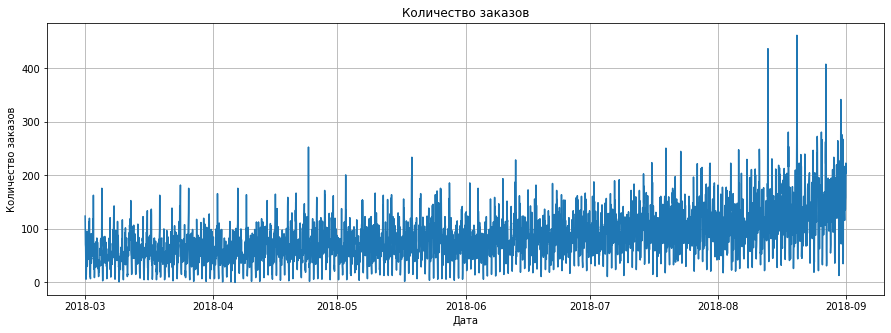

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(df)
plt.title('Количество заказов')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.grid(True)
plt.show();

Временной ряд на графике имеет множественные колебания. Применим скользящее среднее, чтобы снизить колебания во временном ряду.

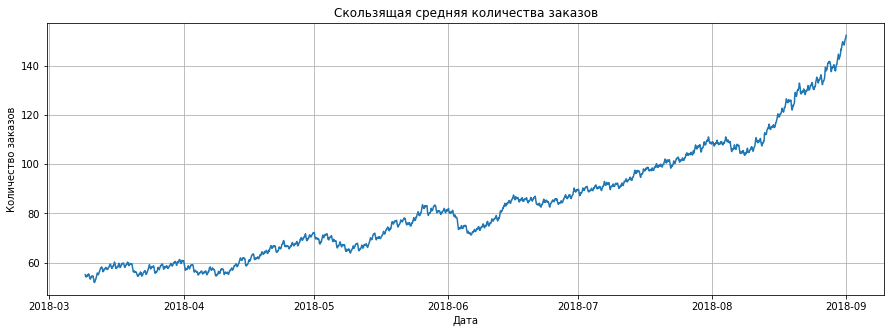

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(df.rolling(200).mean())
plt.title('Скользящая средняя количества заказов')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.grid(True)
plt.show();

С помощью средней скользящей снизили колебания, видим восходящий тренд и повторяющиеся колебания. Применим декомпозицию, чтобы выделить и изучить эти компоненты отдельно.

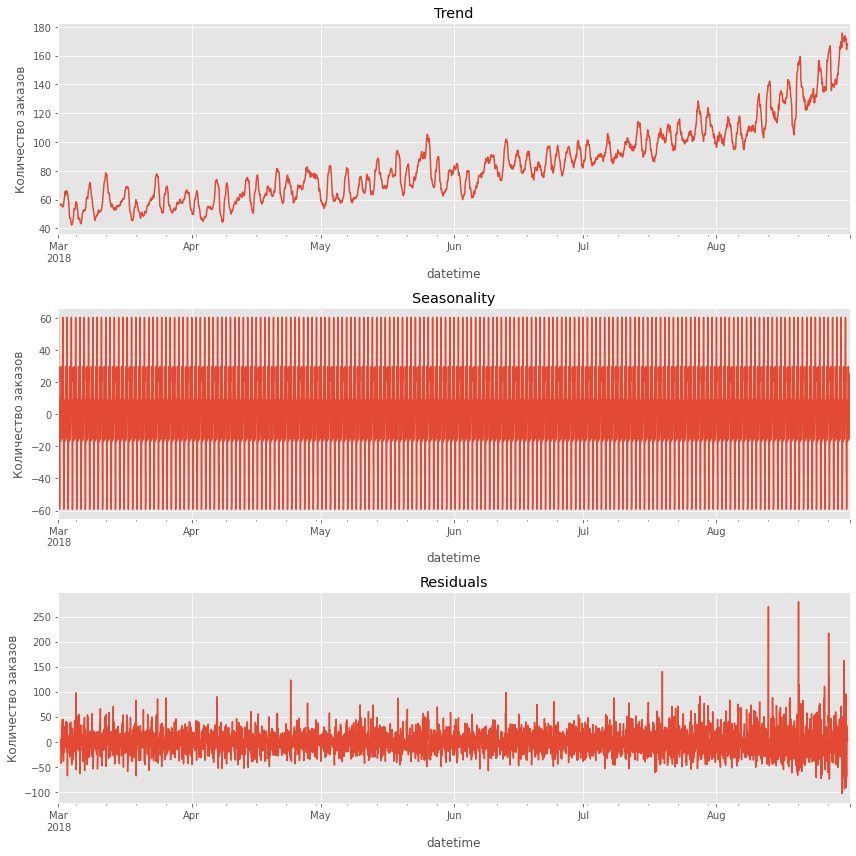

In [10]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(df)
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Количество заказов')

plt.subplot(312)
plt.ylabel('Количество заказов')
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.ylabel('Количество заказов')
plt.tight_layout()

Графики показывают высокую частотность и суточную сезонность, уменьшим интервал и посмотрим за промежуток `2018-08-01` - `2018-08-02`.

Text(0.5, 0, 'Часы')

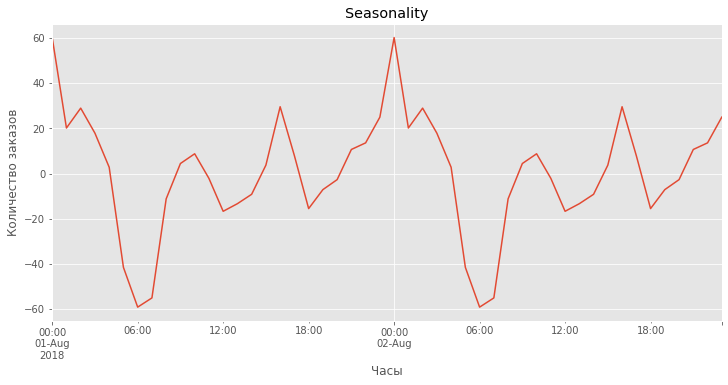

In [11]:
plt.figure(figsize=(12, 12))
plt.subplot(211)
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Количество заказов')
plt.xlabel('Часы')

Разложение временного ряда на тренд, сезонность и остаток показало линейное увеличение заказов на протяжении года - положительный тренд (Это может указывать на постепенное увеличение спроса или развитие бизнеса в данной области.), также случайная часть имеет постоянной среднее значение, но периодически возникают большие всплески (объясняются повышенным спросом на такси по выходным и праздникам). Наблюдается сезонность по часам, где заказы достигают минимума в ночное время, затем возрастают с утра и в течение дня, достигая пика к вечеру. Это может быть связано с часами работы общественного транспорта.

Сделаем ресемплирование по дням и посмотрим сезонность.

In [12]:
df_taxi_day = df.resample('1D').sum()

In [13]:
decomposed = seasonal_decompose(df_taxi_day) 

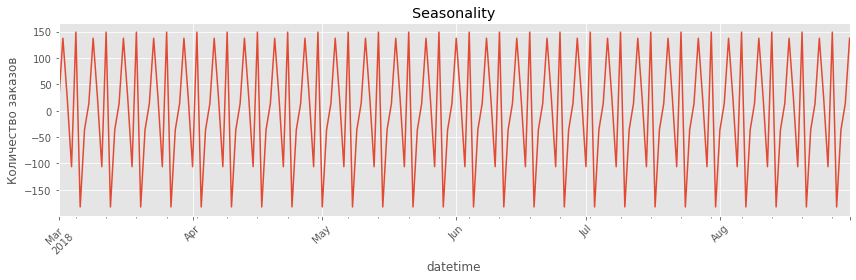

In [14]:
plt.figure(figsize=(12, 4))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Количество заказов')
ax = plt.gca()
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

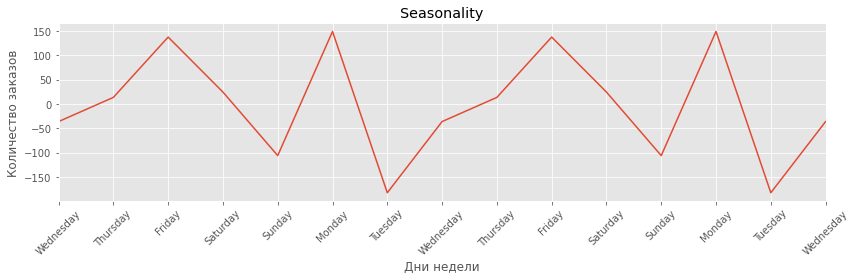

In [15]:
plt.figure(figsize=(12, 4))
decomposed.seasonal['2018-08-01':'2018-08-15'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Количество заказов')
plt.xlabel('Дни недели')
ax = plt.gca()
dates = decomposed.seasonal['2018-08-01':'2018-08-15'].index
day_names = [date.strftime('%A') for date in dates]
ax.set_xticks(dates) 
ax.set_xticklabels(day_names, rotation=45)
plt.tight_layout()
plt.show()

Распределение сезонной части по дням показывает, что меньше всего такси в аэропорт заказывают по воскресеньям и вторникам, больше всего по понедельникам и пятницам.

### Вывод

- Провели разложение данных на тренд, сезонность и остаток
- Тренд показал линейное увеличение заказов на протяжении года
- Случайная часть имеет постоянной среднее значение, но периодически возникают большие всплески
- Наблюдается сезонность по часам где заказы достигают минимума в ночное время, затем возрастают с утра и в течение дня, достигая пика к вечеру
- Распределение сезонной части по дням показывает, что меньше всего такси в аэропорт заказывают по воскресеньям и вторникам, больше всего по понедельникам и пятницам

## Обучение

**Создание признаков**

Создадим признаки:
- Календарные признаки 
- Отстающие значения c `max_lag=24`
- Скользящее среднее за сутки (`24`)
- Скользящее среднее за неделю (`168`), т.к. есть недельная сезонность

In [16]:
def make_features(data, max_lag, rolling_mean_size_24, rolling_mean_size_168):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean_24'] = data['num_orders'].shift().rolling(rolling_mean_size_24).mean()
    data['rolling_mean_168'] = data['num_orders'].shift().rolling(rolling_mean_size_168).mean()
    return data

In [17]:
make_features(df, 24, 24, 168).head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean_24,rolling_mean_168
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.00,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.00,85.00,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.00,71.00,85.00,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df.isna().sum()

num_orders            0
hour                  0
dayofweek             0
lag_1                 1
lag_2                 2
lag_3                 3
lag_4                 4
lag_5                 5
lag_6                 6
lag_7                 7
lag_8                 8
lag_9                 9
lag_10               10
lag_11               11
lag_12               12
lag_13               13
lag_14               14
lag_15               15
lag_16               16
lag_17               17
lag_18               18
lag_19               19
lag_20               20
lag_21               21
lag_22               22
lag_23               23
lag_24               24
rolling_mean_24      24
rolling_mean_168    168
dtype: int64

Проверим признаки на мультиколлинеарность.

In [19]:
!pip install phik -q

     |████████████████████████████████| 686 kB 1.3 MB/s eta 0:00:01


In [20]:
import phik

In [32]:
from phik.report import plot_correlation_matrix

In [29]:
nums = ['num_orders', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
           'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12',
           'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19',
           'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'rolling_mean_24', 'rolling_mean_168']

In [30]:
phik_df = df.phik_matrix(interval_cols=nums)

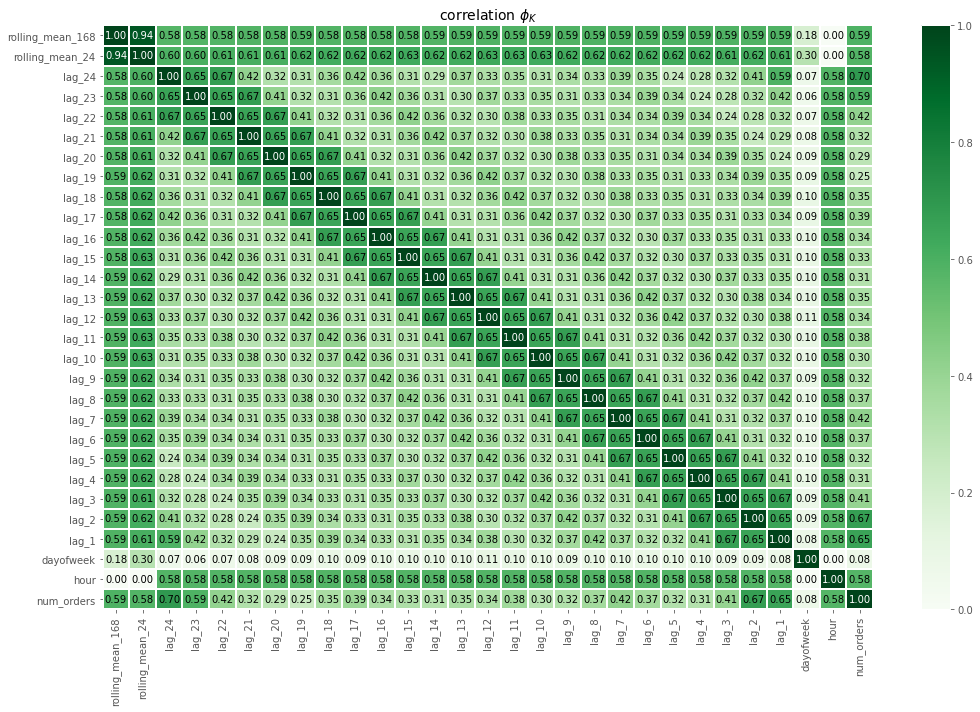

In [34]:
plot_correlation_matrix(phik_df.values, 
                        x_labels=phik_df.columns, 
                        y_labels=phik_df.index,
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 10))

В целом мультиколлинеарность в признаках не наблюдается. Корреляция между `rolling_mean_24` и `rolling_mean_168`  равна 0.94. Это достаточно высокая корреляции, удалим признак `rolling_mean_168`.

In [36]:
df = df.drop(columns='rolling_mean_168')

**Обучение моделей**

Обучим различные модели и добавим модели и рассчитанный `RMSE` в массив `models`.

In [37]:
models = []

In [38]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop(columns='num_orders')
y_train = train['num_orders']
X_test = test.drop(columns='num_orders')
y_test = test['num_orders']

**LinearRegression**

In [39]:
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

cat_col = ['hour', 'dayofweek']
num_col = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
           'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12',
           'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19',
           'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'rolling_mean_24']

encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train_lr[cat_col])
encoder_cat_col = encoder.get_feature_names_out()

X_train_lr[encoder_cat_col] = encoder.transform(X_train_lr[cat_col])
X_test_lr[encoder_cat_col] = encoder.transform(X_test_lr[cat_col])

scaler = StandardScaler()
X_train_lr[num_col] = scaler.fit_transform(X_train_lr[num_col])
X_test_lr[num_col] = scaler.transform(X_test_lr[num_col])

X_train_lr = X_train_lr.drop(cat_col, axis=1)
X_test_lr = X_test_lr.drop(cat_col, axis=1)

lr = LinearRegression()
lr.fit(X_train_lr, y_train)

cv_scores = cross_val_score(lr, X_train_lr, y_train, 
                           scoring='neg_mean_squared_error', 
                           cv=5)
cv_rmse_scores = (-cv_scores)**0.5

print(f"RMSE на кросс-валидации: {cv_rmse_scores.mean()}")

RMSE на кросс-валидации: 24.080070552230353


In [40]:
models.append([lr, cv_rmse_scores.mean()])

**RandomForestRegressor**

In [41]:
rf = RandomForestRegressor()
parameters = {'n_estimators':range(50,100,10), 'max_depth':range(1,11,2)}
tscv = TimeSeriesSplit(n_splits=5)
gsearch_rf = GridSearchCV(estimator=rf, cv=tscv, param_grid=parameters, scoring='neg_root_mean_squared_error')
gsearch_rf.fit(X_train, y_train)
print("Лучшие гиперпараметры:", gsearch_rf.best_params_)
print("RMSE на кросс-валидации:", -gsearch_rf.best_score_)

Лучшие гиперпараметры: {'max_depth': 9, 'n_estimators': 80}
RMSE на кросс-валидации: 25.64577419810584


In [42]:
models.append([rf, -gsearch_rf.best_score_])

**CatBoostRegressor**

In [44]:
cb = CatBoostRegressor(verbose=0, random_state=42) 
parameters = {'iterations':range(50,100,10), 'depth':range(1,11,2), 'learning_rate':[0.01, 0.5]} 
tscv = TimeSeriesSplit(n_splits=5)
gsearch_cb = GridSearchCV(estimator=cb, cv=tscv, param_grid=parameters, scoring='neg_root_mean_squared_error')
gsearch_cb.fit(X_train, y_train)
print("Лучшие гиперпараметры:", gsearch_cb.best_params_)
print("RMSE на кросс-валидации:", -gsearch_cb.best_score_)

Лучшие гиперпараметры: {'depth': 3, 'iterations': 80, 'learning_rate': 0.5}
RMSE на кросс-валидации: 25.163357359995835


In [45]:
models.append([cb, -gsearch_cb.best_score_])

In [46]:
result = pd.DataFrame(models, columns=['model', 'rmse_train'])

In [47]:
result

,model,rmse_train
0,LinearRegression(),24.08
1,RandomForestRegressor(),25.65
2,<catboost.core.CatBoostRegressor object at 0x7...,25.16


### Вывод

- Создали новые признаки:
    - Календарные признаки 
    - Отстающие значения c `max_lag=24`
    - Скользящее среднее за сутки (`24`)
- Обучили модели `LinearRegression`, `RandomForestRegressor`, `CatBoostRegressor`
- `RMSE` на кросс-валидации модели `LinearRegression`: `24.08`
- `RMSE` на кросс-валидации модели `RandomForestRegressor`: `25.64`
- `RMSE` на кросс-валидации модели `CatBoostRegressor`: `25.16`
- Лучшая модель - `LinearRegression`

## Тестирование

In [48]:
# Предсказание на тестовых данных
y_test_pred = lr.predict(X_test_lr)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"RMSE на тестовых данных: {test_rmse:.2f}")

RMSE на тестовых данных: 41.91


In [49]:
def illustration(test, predict):
    model_data = pd.DataFrame({"target": test, "predict": predict})
    ax = model_data.plot(figsize=(18, 6))
    ax.set_title("Сравнение фактических и предсказанных значений")  # Заголовок графика
    ax.set_xlabel("Индекс наблюдения")  # Подпись оси X
    ax.set_ylabel("Значение")  # Подпись оси Y
    return ax

<AxesSubplot:title={'center':'Сравнение фактических и предсказанных значений'}, xlabel='Индекс наблюдения', ylabel='Значение'>

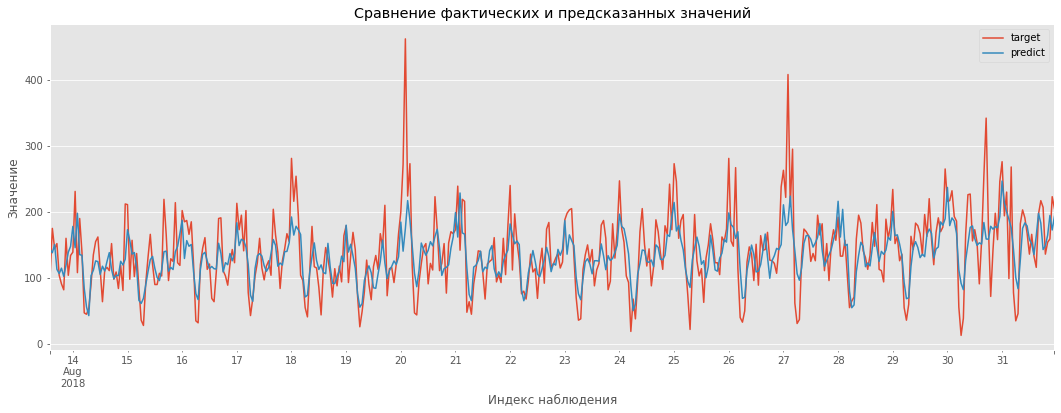

In [50]:
illustration(y_test, y_test_pred)

### Вывод

-`RMSE` на тестовой выборке выбранной модели `LinearRegression` показала значение `41.91`

### Общий вывод

В данном проекте мы построили модель для предсказания количества заказов такси. Были проведены следующие шаги:

1. **Подготовка данных**:
    - В наборе данных `26496` наблюдений
    - Разнообразие значений ряда `81`
    - Отсутствие пропусков
    - Данные ресемплированы, расположены в хронологическом порядке

2. **Анализ данных**
    - Провели разложение данных на тренд, сезонность и остаток
    - Тренд показал линейное увеличение заказов на протяжении года
    - Случайная часть имеет постоянной среднее значение, но периодически возникают большие всплески
    - Наблюдается сезонность по часам где заказы достигают минимума в ночное время, затем возрастают с утра и в течение дня, достигая пика к вечеру
    - Распределение сезонной части по дням показывает, что меньше всего такси в аэропорт заказывают по воскресеньям и вторникам, больше всего по понедельникам и пятницам

3. **Обучение моделей**
    - Создали новые признаки:
        - Календарные признаки 
        - Отстающие значения c `max_lag=24`
        - Скользящее среднее за сутки (`24`)
    - Обучили модели `LinearRegression`, `RandomForestRegressor`, `CatBoostRegressor`
    - `RMSE` на кросс-валидации модели `LinearRegression`: `24.08`
    - `RMSE` на кросс-валидации модели `RandomForestRegressor`: `25.64`
    - `RMSE` на кросс-валидации модели `CatBoostRegressor`: `25.16`
    - Лучшая модель - `LinearRegression`

4. **Тестирование моделей**
    - `RMSE` на тестовой выборке выбранной модели `LinearRegression` показала значение `41.91`